In [70]:
import argparse
import sys
import os
import time
import copy

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import dataset
#from models.conv2_dense2_dropout import Model
from models.dense3 import Model

from helpers.os_utils import os_info
from helpers.history import ExpHistory
from helpers.estimator_utils import create_model_fn, split_datasource

In [71]:
# You may want to rerun and should close the session, if one is open.
try: 
    sess.close()
except NameError:
    print("Don't worry. Need to ignore this error once")
sess = tf.InteractiveSession()

### Get the history and the runtime context 

In [72]:
tf.logging.set_verbosity(tf.logging.INFO)

HIST_FILE_NAME = 'experiment_history.csv'
history = ExpHistory(HIST_FILE_NAME)

localtime = time.asctime(time.localtime(time.time()))
user = os.environ.get('USER', os.environ.get('USERNAME', 'anonymous'))
print("\n\n")
print("Welcome, %s, it's %s, and you'll be working with Tensorflow version %s" % (user, localtime, tf.__version__))
rt=os_info()
this_os = rt['os']
this_node = rt['node']
this_machine = rt['machine']
this_cuda = rt['cuda']
print("Your current runtime: \n  node: %s, \n  os: %s, \n  machine: %s, \n  cuda: %s" % (this_node, this_os, this_machine, this_cuda))
print("\n")
columns=[
    'node', 
    #'os',
    #'machine',
    'cuda',
    'multi_gpu',
    'model',
    'batch_size',
    'data_dir',
    #'model_dir',
    'train_epochs',
    #'user',
    #'time_stamp',
    'localtime',
    'steps',
    'accuracy',
    'duration'
]
history.experiments.tail(10)[columns]




Welcome, wgiersche, it's Sat May  5 16:33:34 2018, and you'll be working with Tensorflow version 1.8.0
Your current runtime: 
  node: scylla, 
  os: Linux-4.13.0-39-generic-x86_64-with-Ubuntu-16.04-xenial, 
  machine: x86_64, 
  cuda: True




,node,cuda,multi_gpu,model,batch_size,data_dir,train_epochs,localtime,steps,accuracy,duration
34,wolfgangs-mac-pro.home,0,0,NaN,64,/var/ellie/data/mnist_fashion,2,Fri May 4 17:31:53 2018,1782.0,0.873333,16.0
35,wolfgangs-mac-pro.home,0,0,NaN,256,/var/ellie/data/mnist_fashion,20,Sat May 5 12:15:34 2018,4454.0,0.895333,46.0
36,wolfgangs-mac-pro.home,0,0,NaN,256,/var/ellie/data/mnist_fashion,10,Sat May 5 15:18:47 2018,2227.0,0.894000,27.0
37,wolfgangs-mac-pro.home,0,0,Conv2-Dense2,256,/var/ellie/data/mnist_fashion,2,Sat May 5 15:43:16 2018,446.0,0.896000,128.0
38,wolfgangs-mac-pro.home,0,0,Dense3,256,/var/ellie/data/mnist_fashion,10,Sat May 5 16:00:07 2018,2227.0,0.892667,26.0
39,scylla,1,0,Conv2-Dense2,256,/var/ellie/data/mnist_fashion,20,Sat May 5 16:19:28 2018,4454.0,0.928000,33.0
40,scylla,1,1,Conv2-Dense2,256,/var/ellie/data/mnist_fashion,20,Sat May 5 16:23:56 2018,4454.0,0.931000,63.0
41,scylla,1,1,Conv2-Dense2,512,/var/ellie/data/mnist_fashion,20,Sat May 5 16:26:29 2018,2227.0,0.935333,36.0
42,scylla,1,1,Conv2-Dense2,1024,/var/ellie/data/mnist_fashion,20,Sat May 5 16:28:32 2018,1114.0,0.928000,24.0
43,scylla,1,1,Conv2-Dense2,1024,/var/ellie/data/mnist_fashion,50,Sat May 5 16:29:54 2018,2784.0,0.932667,52.0


### Want to start with the most recent record from this platform?

In [73]:
hparams=history.suggest_from_history()
#hparams=history.copy_from_record(18)
hparams

node                                                       scylla
os              Linux-4.13.0-39-generic-x86_64-with-Ubuntu-16....
machine                                                    x86_64
cuda                                                         True
multi_gpu                                                       1
model                                                Conv2-Dense2
batch_size                                                   1024
data_dir                            /var/ellie/data/mnist_fashion
model_dir                                        /tmp/mnist_model
train_epochs                                                   50
user                                                    wgiersche
timestamp                                              1525530815
localtime                                Sat May  5 16:33:35 2018
accuracy                                                 0.932667
steps                                                        2784
duration  

### Use as new hyper-parameter record, with adaptations 

In [74]:
#DATA_SET = 'DIGITS'
#hparams.data_dir = '/var/ellie/data/mnist'

DATA_SET = 'FASHION'
hparams.data_dir = '/var/ellie/data/mnist_fashion'

hparams.train_epochs = 200
hparams.batch_size = 1024
hparams.multi_gpu = True
hparams.model = Model.id
hparams

node                                                       scylla
os              Linux-4.13.0-39-generic-x86_64-with-Ubuntu-16....
machine                                                    x86_64
cuda                                                         True
multi_gpu                                                    True
model                                                      Dense3
batch_size                                                   1024
data_dir                            /var/ellie/data/mnist_fashion
model_dir                                        /tmp/mnist_model
train_epochs                                                  200
user                                                    wgiersche
timestamp                                              1525530815
localtime                                Sat May  5 16:33:35 2018
accuracy                                                 0.932667
steps                                                        2784
duration  

### Always have a quick peek at your input data!

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=int32)

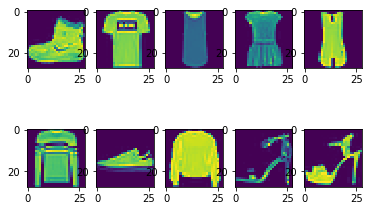

In [75]:
samples = dataset.training_dataset(hparams.data_dir, DATA_SET).batch(10).make_one_shot_iterator().get_next()
samples = sess.run(samples)
f, arr = plt.subplots(2,5)
for row in (0, 1):
    for col in range(5):
        i = 5 * row + col
        img = samples[0][i].reshape([28,28])
        arr[row, col].imshow(img)
samples[1][:10]

# Get to work!

In [76]:
# For the sake of this tutorial, we always start from scratch
!rm -rf /tmp/mnist_model

### The model function constructs the computational graphs for training, eval and test
Note that the actual construction takes place within the Estimator. Thus, none of the the constructing code should be explicitly called from the API client. The Estimator will complain that parts that have been constructed prior to those that itself constructs, don't belong to the same graph. 

In [77]:
model_function = create_model_fn(
    lambda params: Model(params),
    tf.train.AdamOptimizer(),
    tf.losses.sparse_softmax_cross_entropy,
    hparams)

INFO:tensorflow:Replicating the `model_fn` across [u'/device:GPU:0', u'/device:GPU:1'].  Variables are going to be placed on ['/CPU:0'].  Consolidation device is going to be /CPU:0.


Performance depends on the data format, and differs between CPU and GPU computations

In [78]:
data_format = ('channels_first' if tf.test.is_built_with_cuda() else 'channels_last')

### The Estimator is the center piece of Tensorflow's new API

In [79]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=model_function,
    model_dir=hparams.model_dir,
    params={
        'data_format': data_format,
        'multi_gpu': hparams.multi_gpu
    })

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7facee7344d0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/mnist_model', '_global_id_in_cluster': 0, '_save_summary_steps': 100}


##### ```input_fn``` functions are a factories for ```DataSet```s

### Split the training dataset into training and evaluation sets

In [80]:
def train_input_fn():
    ds_tr = dataset.training_dataset(hparams.data_dir, DATA_SET)
    ds_tr_tr, _ = split_datasource(ds_tr, 60000, 0.95)
    ds1 = ds_tr_tr.cache().shuffle(buffer_size=57000).\
        repeat(hparams.train_epochs).\
        batch(hparams.batch_size)
    return ds1

def eval_input_fn():
    ds_tr = dataset.training_dataset(hparams.data_dir, DATA_SET)
    _, ds_tr_ev = split_datasource(ds_tr, 60000, 0.95)
    ds2 = ds_tr_ev.batch(hparams.batch_size)
    return ds2

### Logging hooks

In [81]:
tensors_to_log = {'train_accuracy': 'train_accuracy'}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=1000)

### Run the training and report the new hyper-parameters 

In [82]:
# Train
start_time=time.time()
mnist_classifier.train(input_fn=train_input_fn, hooks=[logging_hook])
duration=time.time() - start_time

# Evaluate
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
hparams.accuracy = eval_results['accuracy']
hparams.steps = eval_results['global_step']
hparams.duration = int(duration)

# Report!
history.report_experiment(hparams)

print('Evaluation results:\n\t%s' % eval_results)
hparams

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mnist_model/model.ckpt.
INFO:tensorflow:train_accuracy = 0.10546875
INFO:tensorflow:loss = 2.3505535, step = 0
INFO:tensorflow:global_step/sec: 115.338
INFO:tensorflow:loss = 0.401721, step = 100 (0.867 sec)
INFO:tensorflow:global_step/sec: 140.005
INFO:tensorflow:loss = 0.33196053, step = 200 (0.714 sec)
INFO:tensorflow:global_step/sec: 141.361
INFO:tensorflow:loss = 0.30660453, step = 300 (0.708 sec)
INFO:tensorflow:global_step/sec: 140.334
INFO:tensorflow:loss = 0.25796607, step = 400 (0.712 sec)
INFO:tensorflow:global_step/sec: 140.807
INFO:tensorflow:loss = 0.27194184, step = 500 (0.710 sec)
INFO:tensorflow:global_step/sec: 143.619
INFO:tensorflow:loss = 0.22381325, step = 600 (0.696 sec)
INFO:tens

node                                                       scylla
os              Linux-4.13.0-39-generic-x86_64-with-Ubuntu-16....
machine                                                    x86_64
cuda                                                         True
multi_gpu                                                    True
model                                                      Dense3
batch_size                                                   1024
data_dir                            /var/ellie/data/mnist_fashion
model_dir                                        /tmp/mnist_model
train_epochs                                                  200
user                                                    wgiersche
timestamp                                              1525530815
localtime                                Sat May  5 16:33:35 2018
accuracy                                                    0.903
steps                                                       11133
duration  